# 3. 전처리

1. 타이틀, 태그 불용어 처리
2. 타이틀 중복된 플레이리스트 제거
3. 플리별 노래 개수, 좋아요 수 이상치 행 날리기 (태그는 보고 진행)
4. 송, 태그 빈도수에 따라 리스트에서 빼기 -> 리스트가 비워져 있으면 행 날리기

In [2]:
import json
import pandas as pd
import numpy as np
from emoji import core
import re
import ast
from matplotlib import pyplot as plt

In [3]:

playlists = pd.read_json('../0_data/playlists.json', typ = 'frame', encoding='utf-8')
song_meta = pd.read_json('../0_data/song_meta.json', typ = 'frame', encoding='utf-8') 
genre_gn_all = pd.read_json('../0_data/genre_gn_all.json', typ = 'frame', encoding='utf-8', orient='index')

## 1) 오류 및 불용어 처리

### song_meta

> 1. 날짜 오류 수정

In [4]:
# 날짜 오류있는 행 확인
song_meta[song_meta['issue_date'] > 20220000] # index : 141185, 448286

indices_to_update = [141185, 448286]
new_value = 20200113 # 알맞는 발매날짜
# 특정 행의 'issue_date' 값을 변경
for idx in indices_to_update:
    song_meta.at[idx, 'issue_date'] = new_value

In [5]:
# 알맞게 변경되었는지 확인
song_meta.iloc[[141185, 448286], :]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
141185,[GN1801],20200113,고요한 밤바다 구경하기 [여수 바다],10403230,[2737142],잔잔한 바람이 불어와 (There is a gentle breeze),[GN1800],[무드홀릭 (Moodholic)],141185
448286,[GN1801],20200113,고요한 밤바다 구경하기 [여수 바다],10403230,[2737142],여수 바다 (Yeosu sea),[GN1800],[무드홀릭 (Moodholic)],448286


> 2. 대분류 장르 GN9000노래 삭제

In [6]:
song_meta[song_meta['song_gn_gnr_basket'].apply(lambda x: 'GN9000' in x)] # 1834개
song_meta = song_meta[~song_meta['song_gn_gnr_basket'].apply(lambda x: 'GN9000' in x)] # 삭제

In [7]:
# 삭제되었는지 확인
song_meta[song_meta['song_gn_gnr_basket'].apply(lambda x: 'GN9000' in x)]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id


In [8]:
# song_meta 저장
song_meta.to_json('../0_data/song_meta_filter_h.json', orient='records')

- song_meta에 필요한 행만 남긴 버전 + 장르 매핑된 버전이 필요함!

### 2. playlists

> 1. 타이틀, 태그 불용어 처리

- 타이틀 특수 문자 제거

In [9]:
# 이모지 제거 함수
def replace_emoji(inputString):
    return core.replace_emoji(inputString, replace='')

# 특수문자 제거 함수
def clean_text(inputString):
  text_rmv = re.sub('[-=+,#/\?:^●○.@*\"※~ㆍ!<>$♥❤♡☆★♪♬♩¶♨①๑｡＊②ఇ¥◈ ͡✔ ͡° ͜ʖ▶◀◎ღ✿ﾉ ;\\\_■『│』ᕷⓗ‘|\(\)\[\]`\'…》\”\“\’·]',' ', inputString)
  return text_rmv

In [10]:

# # 이모지 제거 함수 적용
playlists['plylst_title'] = playlists['plylst_title'].apply(replace_emoji)

# 특수문자 제거 함수 적용
playlists['plylst_title'] = playlists['plylst_title'].apply(clean_text)

In [11]:
# 양 옆 공백, %, & 제거

playlists['plylst_title'] = playlists['plylst_title'].str.strip()
playlists['plylst_title'] = playlists['plylst_title'].str.strip('%')
playlists['plylst_title'] = playlists['plylst_title'].str.strip('&')

In [16]:
playlists.iloc[[56134, 59162],:] # 확인

,tags,id,plylst_title,songs,like_cnt,updt_date
56134,[흥폭발],22525,내적댄스 터져베이베 아이돌 노래노래,"[108003, 594076, 297411, 97189, 35713, 445680,...",41,2018-06-15 19:24:26.000
59162,"[가을, 설렘, 사랑]",143039,가을이다 o 곧 겨울이다 T T,"[13142, 5049, 503816, 70166, 578529, 336829, 2...",1,2018-07-31 10:55:04.000


- 불용어 제거 시 영어는 제거 안되는 문제 탐색

In [25]:
def has_english_characters(input_string):
    # 정규 표현식을 사용하여 문자열에서 영어 문자를 검색
    # [a-zA-Z]는 영어 대소문자를 나타냅니다.
    pattern = re.compile('[a-zA-Z]')
    
    # 문자열에서 영어 문자 검색
    result = pattern.search(input_string)
    
    # 검색 결과가 None이면 영어 문자가 없음을 의미
    return result is not None

playlists['has_english'] = playlists['plylst_title'].apply(lambda x: 1 if has_english_characters(x) else 0)

In [26]:
playlists['has_english'].value_counts()

0    88066
1    27005
Name: has_english, dtype: int64

In [27]:
playlists[playlists['has_english'] == 1]

,tags,id,plylst_title,songs,like_cnt,updt_date,has_english
5,"[운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...",69252,2017 Pop Trend,"[418694, 222305, 96545, 135950, 304687, 457451...",435,2017-09-15 15:59:26.000,1
8,"[일렉트로니카, 포크, 메탈, 락, 댄스, 인디]",70741,DANCING IN THE MOON LIGHT 01,"[634861, 270738, 163936, 692209, 449477, 56342...",0,2019-11-30 21:17:59.000,1
9,"[록, Metal, 이일우, M에센셜, 메탈, Rock, 락]",10288,록 메탈 Written by 이일우,"[613315, 439294, 230806, 497932, 113479, 93506...",7,2016-06-17 18:23:54.000,1
11,"[새해, 여행, 프로필음악, 카카오톡, 기분전환, 소원, 프로필, 소망, 다짐, 카톡]",151693,노래로 의지를 불태우자 1일1다짐 st용 프로필뮤직,"[658738, 698779, 124485, 512610, 310028, 17422...",42,2017-02-16 15:45:23.000,1
13,"[힙합, 느낌있는, 밤, 새벽, RnB, 감각적인, 드라이브, 국내, 그루브한]",89809,트렌디하고 그루브한 힙합 알앤비 MUSIC,"[525152, 38765, 66139, 696379, 397438, 144461,...",1112,2018-01-09 14:01:53.000,1
...,...,...,...,...,...,...,...
115064,[JPOP],145872,meltedmoon s tastes 1,"[68191, 231806, 642423, 652037, 522165, 139541...",4,2010-02-27 04:43:19.000,1
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E SM 2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,1
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,1
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,1


=> 영어가 있으면 다 지우기엔 의미있는 타이틀이 너무 많다.

In [29]:
# plyst_title에서 영어 알파벳 개수를 세는 함수
def count_english_characters(input_string):
    pattern = re.compile('[a-zA-Z]')
    result = pattern.findall(input_string)
    return len(result)

# 새로운 열 'english_char_count'를 추가하여 영어 알파벳 개수를 할당
playlists['english_char_count'] = playlists['plylst_title'].apply(lambda x: count_english_characters(x))

In [31]:
playlists['english_char_count'].value_counts()

0     88066
3      6797
4      3111
2      2359
6      1782
5      1322
8      1269
9      1228
7      1214
10     1210
12      948
11      922
13      670
14      613
1       560
16      465
15      446
17      334
18      318
19      311
20      218
23      182
21      173
22      134
24      121
25       64
26       50
27       45
29       36
28       34
31       25
30       20
32       10
33        5
40        4
34        4
36        1
Name: english_char_count, dtype: int64

In [33]:
playlists['english_char_count'].describe()

count    115071.000000
mean          1.684195
std           4.056477
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          40.000000
Name: english_char_count, dtype: float64

In [39]:
playlists[(playlists['english_char_count'] <= 1) & (playlists['english_char_count'] != 0)]

,tags,id,plylst_title,songs,like_cnt,updt_date,has_english,english_char_count
144,"[싱어송라이터, 영국, 기타]",50570,기타 들고 노래하는 영국 뮤지션s,"[118195, 316930, 54656, 459594, 505453, 255937...",18,2019-03-10 02:16:25.000,1,1
659,"[추억회상, 1990, 아재, 응답하라, 발라드, 댄스, 복고, 세대공감, 30대,...",18865,요즘 십대들은 잘 모르는 노래 90s,"[283296, 355062, 660845, 87481, 488872, 683755...",121,2017-04-13 13:09:27.000,1,1
855,"[중2병, 밴드, 락, 락메탈]",52066,나의 중2병이 락에 심취했ㄷr,"[11060, 120865, 148875, 568471, 10096, 595953,...",2,2020-04-22 03:23:29.000,1,1
900,[발라드],138077,90 s 이노래 그때 그노래,"[401250, 204866, 552540, 563645, 634710, 27953...",96,2015-04-30 21:46:44.000,1,1
1251,"[설렘, 사랑]",65676,D 초콜릿보다 달콤한 사랑이야기,"[643765, 477228, 423503, 623361, 496344, 53643...",2116,2011-02-11 01:58:33.000,1,1
...,...,...,...,...,...,...,...,...
114368,[댄스],79057,90 s,"[446180, 106990, 510464, 377807, 688756, 38954...",2,2014-04-29 17:26:58.000,1,1
114417,[댄스],38904,제왚 내이션 D 4 제알못을 위한 제왚 페밀리 플레이리스트,"[642536, 211281, 157846, 526811, 424709, 14864...",6,2016-08-02 21:46:30.000,1,1
114566,"[기분좋은, 소풍, 드라이브, 공원, 여행, 기분전환, 산책, 자전거]",20231,같이 소풍갈래 D,"[422945, 166676, 225426, 47106, 169531, 25958,...",197,2020-04-19 00:59:51.000,1,1
114875,[리시차],151006,발렌티나S2리시차 검반위검투사,"[492741, 329241, 285654, 504206, 493054, 32770...",5,2019-04-08 21:05:37.000,1,1


=> 영단어 개수로도 전처리 불가

In [43]:
# has_english, english_char_count 컬럼 삭제
playlists.drop(labels=['has_english','english_char_count'], axis=1, inplace=True)

In [44]:
# 확인
playlists.head()

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,편하게 잔잔하게 들을 수 있는 곡,"[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000


- 태그 특수문자 제거

In [46]:
# 특수문자 '_'가 있는 행 찾기
# '_'가 있는 행 찾기
rows_with_underscore = playlists['tags'][playlists['tags'].apply(lambda x: any('_' in tag for tag in x))]
rows_with_underscore

Series([], Name: tags, dtype: object)

In [47]:
# 특수 문자를 제거하는 함수 정의
def remove_special_characters(tag_list):
    cleaned_tags = []
    for tag in tag_list:
        cleaned_tag = re.sub(r'[^\uAC00-\uD7A30-9a-zA-Z\s]', '', tag).replace(" ", "")
        cleaned_tags.append(cleaned_tag)
    return cleaned_tags

# 함수 적용
playlists['tags'] = playlists['tags'].apply(remove_special_characters)

In [48]:
playlists.iloc[[148, 285, 115068], :] # 확인

,tags,id,plylst_title,songs,like_cnt,updt_date
148,"[비오는날, 비오는날, 휴식, 비오는날, 비]",32533,비오는날 감성 자극 듣기 좋은 어쿠스틱 피아노 발라드,"[133091, 527764, 468136, 260894, 22845, 148876...",14,2020-02-16 00:56:45.000
285,"[상쾌해지는, 호불호없는, 모두가흥얼흥얼]",151357,기분좋아지는 노래들,"[270061, 158766, 573179, 272062, 37027, 245028...",0,2019-11-24 05:49:55.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의이야기, 사랑, 친구]",11343,1 눈물이 앞을 가리는 나의 이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000


In [49]:
# 플레이리스트 타이틀이 1글자인 조건 만들기
playlists_title_1str = playlists[playlists['plylst_title'].str.len() == 1]
playlists_title_1str = list(playlists_title_1str['id'].values) # 24 -> 롹, 잠, 쿨, 힙 등이며 대부분 좋아요 0 또는 1
# playlists[playlists['id'] == 98628]

# 삭제
playlists = playlists[playlists['plylst_title'].str.len() != 1]

In [50]:
# 빈 타이틀 삭제
playlists = playlists[playlists['plylst_title'] != '']

# 숫자로만 구성된 타이틀 삭제
numeric_title_rows = playlists[playlists['plylst_title'].str.isnumeric()]
indices_to_remove = numeric_title_rows.index
playlists = playlists.drop(indices_to_remove)

playlists.info()


# 115071 - 114707 = 364행 삭제

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114707 entries, 0 to 115070
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          114707 non-null  object
 1   id            114707 non-null  int64 
 2   plylst_title  114707 non-null  object
 3   songs         114707 non-null  object
 4   like_cnt      114707 non-null  int64 
 5   updt_date     114707 non-null  object
dtypes: int64(2), object(4)
memory usage: 6.1+ MB


## 2) 타이틀 중복 제거(기준 : 노래 개수 or 좋아요 개수)

In [51]:
# 1. 플레이리스트 아이디(id)와 플레이리스트 명(plylst_title) 추출
plylst_title = playlists[['id', 'plylst_title']]

# 2. 플레이리스트 이름 별 플레이리스트 ID count 테이블 생성 : plylst_id_cnt
plylst_id_cnt = plylst_title.groupby('plylst_title').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 3. 플레이리스트 명 중복 구분 : 서로 다른 플레이리스트 아이디로 겹치는 플레이리스트 이름이 없으면 '중복 없음', 그 외 '중복 있음'
plylst_id_cnt = plylst_id_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(plylst_id_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['중복 없음', '중복 있음'])
)
plylst_id_cnt
# [0, 1, np.inf] : 0이상 1미만 값 = 중복없음, 1이상의 값 = 중복있음

# 4. 중복 구분 별 플레이리스트 수 count 테이블 생성 : plylst_id_cnt_division
plylst_id_cnt_division = pd.DataFrame(plylst_id_cnt.groupby('mapping_plylst_cnt_category').count())
plylst_id_cnt_division

,plylst_title,mapping_plylst_cnt
mapping_plylst_cnt_category,,
중복 없음,106525,106525
중복 있음,2722,2722


In [52]:
# 플레이리스트 타이틀을 기준으로 merge해 중복된 플레이리스트만 확인
playlists_dup = pd.merge(playlists, plylst_id_cnt, on='plylst_title')
playlists_dup= playlists_dup[playlists_dup['mapping_plylst_cnt_category'] == '중복 있음']
playlists_dup['song_cnt'] = playlists_dup['songs'].apply(len)
playlists_dup['tag_cnt'] = playlists_dup['tags'].apply(len)
playlists_dup.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,mapping_plylst_cnt,mapping_plylst_cnt_category,song_cnt,tag_cnt
16,"[감성, 질리지않는, 나만알고싶은, Pop]",1516,나만 알고싶은 노래들,"[331055, 99287, 310974, 376435, 146989, 430106...",1,2018-01-02 12:10:59.000,4,중복 있음,31,4
17,"[기분전환, 까페]",86179,나만 알고싶은 노래들,"[480142, 578916, 467225, 701072, 197046, 63557...",6,2016-10-06 02:08:40.000,4,중복 있음,46,2
18,"[숨은명곡, 좋은노래]",54673,나만 알고싶은 노래들,"[113618, 422482, 380069, 75425, 79141, 657137,...",7,2016-07-15 10:20:17.000,4,중복 있음,23,2
19,"[감성힙합, 나만알고싶은, 뿜뿜, 그루브, 노래, 감성]",135616,나만 알고싶은 노래들,"[470548, 603591, 382764, 288501, 187291, 37802...",30,2018-07-13 08:18:54.000,4,중복 있음,45,6
44,"[기분전환, 가을]",105328,트렌디한 Cafe Pop Music,"[419702, 403579, 472776, 502078, 662300, 44363...",55,2014-09-18 11:29:55.000,2,중복 있음,16,2


In [54]:
# 같은 타이틀을 가진 플레이리스트의 노래 개수 비교
# playlists_dup에서 타이틀별로 groupby 후 song_cnt 값들을 song_cnt_nunique(새 컬럼)에 리스트 형태로 넣은 후 중복을 없애기 위해 set 진행
# 1의 의미는 노래 갯수가 중복되어 있다는 뜻이기 때문에 1의 갯수가 적은 지표를 기준으로 중복 플레이리스트 제거를 진행해야함
from collections import Counter

playlists_dup_song_cnt = playlists_dup.groupby('plylst_title')['song_cnt'].apply(list).reset_index()
playlists_dup_song_cnt['song_cnt_nunique'] = playlists_dup_song_cnt['song_cnt'].apply(lambda x: len(set(x)))
Counter(playlists_dup_song_cnt['song_cnt_nunique'])

Counter({2: 1543,
         1: 510,
         3: 343,
         4: 130,
         5: 56,
         6: 47,
         7: 30,
         8: 17,
         9: 9,
         11: 8,
         14: 5,
         15: 5,
         10: 5,
         16: 3,
         13: 3,
         20: 2,
         12: 2,
         25: 1,
         19: 1,
         22: 1,
         17: 1})

In [55]:
# 같은 타이틀을 가진 플레이리스트의 태그 개수 비교

playlists_dup_tag_cnt = playlists_dup.groupby('plylst_title')['tag_cnt'].apply(list).reset_index()
playlists_dup_tag_cnt['tag_cnt_nunique'] = playlists_dup_tag_cnt['tag_cnt'].apply(lambda x: len(set(x)))
Counter(playlists_dup_tag_cnt['tag_cnt_nunique'])

Counter({1: 1225, 2: 1222, 3: 183, 4: 59, 5: 20, 6: 9, 7: 4})

In [56]:
# 같은 타이틀을 가진 플레이리스트의 좋아요 비교

playlists_dup_like_cnt = playlists_dup.groupby('plylst_title')['like_cnt'].apply(list).reset_index()
playlists_dup_like_cnt['like_cnt_nunique'] = playlists_dup_like_cnt['like_cnt'].apply(lambda x: len(set(x)))
Counter(playlists_dup_like_cnt['like_cnt_nunique'])

Counter({2: 1741,
         1: 431,
         3: 311,
         4: 102,
         5: 54,
         6: 32,
         7: 14,
         8: 10,
         9: 7,
         12: 5,
         11: 4,
         10: 4,
         13: 2,
         14: 2,
         15: 1,
         18: 1,
         24: 1})

- 플레이리스트 타이틀이 중복인 플레이리스트만 따로 모으고
- 그 중복 플리모음 중 노래갯수가 가장 많은 하나만 남겨두고
- 원래 train의 중복 없음만 따로 모아 중복모음과 concat

In [57]:
# train에 중복 갯수, 중복 여부 컬럼 추가, 플레이리스트 내 곡 갯수 추가
playlists_add_col = pd.merge(playlists, plylst_id_cnt, on='plylst_title')
playlists_add_col['song_cnt'] = playlists_add_col['songs'].apply(lambda x : len(x))

# 매핑갯수, 타이틀, 플리 내 노래 갯수, like_cnt 내림차순 정렬
playlists_filter = playlists_add_col.sort_values(['mapping_plylst_cnt', 'plylst_title', 'song_cnt', 'like_cnt'], ascending=False)
playlists_filter

,tags,id,plylst_title,songs,like_cnt,updt_date,mapping_plylst_cnt,mapping_plylst_cnt_category,song_cnt
8532,"[집중, 어쿠스틱, 혼자, 발라드, 우울, 드라이브, 산책, 조용조용, 띵곡들, 인디]",152785,혼자만의 시간이 필요할때,"[208812, 629738, 232874, 13281, 193232, 389468...",1,2020-03-26 06:14:54.000,43,중복 있음,81
8519,"[어쿠스틱, 혼자, 발라드, 우울, 분위기, 드라이브, 띵곡만, 산책, 운전, 인디]",127180,혼자만의 시간이 필요할때,"[570836, 209135, 389920, 105140, 582252, 38261...",1,2020-03-24 06:39:20.000,43,중복 있음,78
8536,"[띵곡, 혼자만, 어쿠스틱, 발라드, 우울, 분위기, 드라이브, 조용한, 산책, 인디]",76448,혼자만의 시간이 필요할때,"[570836, 209135, 389920, 105140, 582252, 38261...",1,2020-04-13 05:56:55.000,43,중복 있음,78
8541,"[어쿠스틱, 혼자, 발라드, 우울, 분위기, 드라이브, 조용한, 산책, 띵곡들, 인디]",141114,혼자만의 시간이 필요할때,"[484964, 626369, 570836, 366786, 413837, 20913...",1,2020-04-22 06:38:57.000,43,중복 있음,78
8548,"[어쿠스틱, 혼자, 발라드, 분위기, 드라이브, 조용한, 산책, 운전, 띵곡들, 인디]",18201,혼자만의 시간이 필요할때,"[484964, 626369, 570836, 366786, 413837, 20913...",1,2020-04-06 05:20:46.000,43,중복 있음,78
...,...,...,...,...,...,...,...,...,...
31846,[일렉],56144,00 Party 일렉트로댄스,"[256418, 183424, 431998, 654442, 354592, 24132...",7,2018-02-06 16:02:42.000,1,중복 없음,20
17805,[일렉],58768,00 Electronica EDM,"[673003, 251403, 617690, 441958, 436128, 62788...",5,2020-01-05 00:24:22.000,1,중복 없음,133
108585,[일렉],110536,0 일렉듣고 광질준비 O K ElecVVIP,"[349306, 93890, 651902, 46845, 362347, 330768,...",173,2012-11-29 14:34:56.000,1,중복 없음,59
52783,"[비오는날, 추억, 회상]",106660,비오는날 듣기 좋은 연주곡 모음,"[79329, 51922, 173875, 216115, 422584, 509605,...",6,2015-10-06 11:45:24.000,1,중복 없음,25


In [58]:
playlists_dup = playlists_filter[playlists_filter['mapping_plylst_cnt_category'] == '중복 있음'] # 중복 플리 모음
playlists_dup['plylst_title'].nunique() # 중복된 플레이리스트의 유니크 타이틀 갯수 : 2723

2722

In [59]:

playlists_dup['tag_cnt'] = playlists_dup['tags'].apply(len)
playlists_dup.head()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_10096\1348730183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playlists_dup['tag_cnt'] = playlists_dup['tags'].apply(len)


,tags,id,plylst_title,songs,like_cnt,updt_date,mapping_plylst_cnt,mapping_plylst_cnt_category,song_cnt,tag_cnt
8532,"[집중, 어쿠스틱, 혼자, 발라드, 우울, 드라이브, 산책, 조용조용, 띵곡들, 인디]",152785,혼자만의 시간이 필요할때,"[208812, 629738, 232874, 13281, 193232, 389468...",1,2020-03-26 06:14:54.000,43,중복 있음,81,10
8519,"[어쿠스틱, 혼자, 발라드, 우울, 분위기, 드라이브, 띵곡만, 산책, 운전, 인디]",127180,혼자만의 시간이 필요할때,"[570836, 209135, 389920, 105140, 582252, 38261...",1,2020-03-24 06:39:20.000,43,중복 있음,78,10
8536,"[띵곡, 혼자만, 어쿠스틱, 발라드, 우울, 분위기, 드라이브, 조용한, 산책, 인디]",76448,혼자만의 시간이 필요할때,"[570836, 209135, 389920, 105140, 582252, 38261...",1,2020-04-13 05:56:55.000,43,중복 있음,78,10
8541,"[어쿠스틱, 혼자, 발라드, 우울, 분위기, 드라이브, 조용한, 산책, 띵곡들, 인디]",141114,혼자만의 시간이 필요할때,"[484964, 626369, 570836, 366786, 413837, 20913...",1,2020-04-22 06:38:57.000,43,중복 있음,78,10
8548,"[어쿠스틱, 혼자, 발라드, 분위기, 드라이브, 조용한, 산책, 운전, 띵곡들, 인디]",18201,혼자만의 시간이 필요할때,"[484964, 626369, 570836, 366786, 413837, 20913...",1,2020-04-06 05:20:46.000,43,중복 있음,78,10


In [61]:
# playlists_dup 중 각 플리 제목 별 노래갯수가 가장 많은 하나만 남긴다
playlists_dup_filter = pd.DataFrame(playlists_dup[playlists_dup.groupby('plylst_title')['song_cnt'].transform(max) == playlists_dup['song_cnt']]) # 3572 
playlists_dup_filter = pd.DataFrame(playlists_dup_filter[playlists_dup_filter.groupby('plylst_title')['like_cnt'].transform(max) == playlists_dup_filter['like_cnt']]) # 2928 
playlists_dup_filter = pd.DataFrame(playlists_dup_filter[playlists_dup_filter.groupby('plylst_title')['tag_cnt'].transform(max) == playlists_dup_filter['tag_cnt']]) # 2909 
playlists_dup_filter = pd.DataFrame(playlists_dup_filter[playlists_dup_filter.groupby('plylst_title')['updt_date'].transform(max) == playlists_dup_filter['updt_date']]) # 2748 
playlists_dup_filter

,tags,id,plylst_title,songs,like_cnt,updt_date,mapping_plylst_cnt,mapping_plylst_cnt_category,song_cnt,tag_cnt
8532,"[집중, 어쿠스틱, 혼자, 발라드, 우울, 드라이브, 산책, 조용조용, 띵곡들, 인디]",152785,혼자만의 시간이 필요할때,"[208812, 629738, 232874, 13281, 193232, 389468...",1,2020-03-26 06:14:54.000,43,중복 있음,81,10
3119,[비오는날듣기좋은노래],75012,비오는날,"[65672, 522825, 145252, 146780, 500731, 473608...",22,2017-08-19 15:16:36.000,34,중복 있음,200,1
5536,"[조용히, 어쿠스틱, 여유, 발라드, 분위기, 힐링, 자기전이나, 띵곡, 인디, 편안한]",52312,자기전 하루한곡 발라드,"[570836, 209135, 389920, 105140, 582252, 38261...",1,2020-04-02 06:54:25.000,31,중복 있음,82,10
8429,[금요일],48129,금요일,"[614756, 147427, 340332, 675466, 414036, 61619...",0,2017-03-10 17:31:34.000,30,중복 있음,20,1
7288,[발라드],5960,추억,"[208821, 481749, 565402, 362197, 407236, 46604...",10,2010-10-21 09:45:12.000,27,중복 있음,85,1
...,...,...,...,...,...,...,...,...,...,...
155,"[기분좋은, 100번]",148495,100번 들어도 기분좋은 가요,"[208186, 155952, 669617, 438439, 397412, 60398...",4,2016-10-31 13:59:41.000,2,중복 있음,16,2
76640,[Pop],62278,100% 로맨틱 조지 마이클 223,"[366485, 435804, 442680, 538949, 263360, 29495...",0,2019-03-27 15:27:44.000,2,중복 있음,34,1
34444,[팝],50564,1 HITS OF DECADE SPECIAL 2,"[60025, 326802, 82991, 533287, 404318, 82686, ...",5,2009-07-11 21:37:42.000,2,중복 있음,37,1
75854,[팝],109558,1 HITS OF DECADE SPECIAL,"[289618, 78629, 349460, 218356, 189583, 613209...",5,2009-07-05 18:23:47.000,2,중복 있음,39,1


In [62]:
playlists_dup_filter[playlists_dup_filter['plylst_title'] == 'qqqa'] # 필터링 되지 않은 중복 타이틀은 플레이리스트 자체가 같음

,tags,id,plylst_title,songs,like_cnt,updt_date,mapping_plylst_cnt,mapping_plylst_cnt_category,song_cnt,tag_cnt
50442,[여름],7524,qqqa,"[522825, 455668, 549178, 407828, 343974]",1,2015-11-04 17:51:14.000,3,중복 있음,5,1
50443,[여름],43031,qqqa,"[522825, 455668, 549178, 407828, 343974]",1,2015-11-04 17:51:14.000,3,중복 있음,5,1


In [63]:
# 타이틀이 같은 플레이리스트 중 하나만 남긴다
playlists_dup_filter = pd.DataFrame(playlists_dup_filter.groupby('plylst_title', group_keys=False).apply(lambda x: x.loc[x['song_cnt'].idxmax()]))
playlists_dup_filter = playlists_dup_filter.reset_index(drop=True) # 2722

In [64]:
# playlists_dup_filter 중 중복 여부 확인

# 1. 플레이리스트 아이디(id)와 플레이리스트 명(plylst_title) 추출
plylst_title_2 = playlists_dup_filter[['id', 'plylst_title']]

# 2. 플레이리스트 이름 별 플레이리스트 ID count 테이블 생성 : plylst_id_cnt
plylst_id_cnt_2 = plylst_title_2.groupby('plylst_title').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 3. 플레이리스트 명 중복 구분 : 서로 다른 플레이리스트 아이디로 겹치는 플레이리스트 이름이 없으면 '중복 없음', 그 외 '중복 있음'
plylst_id_cnt_2 = plylst_id_cnt_2.assign(
    mapping_plylst_cnt_category = pd.cut(plylst_id_cnt_2['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['중복 없음', '중복 있음'])
)
plylst_id_cnt_2
# [0, 1, np.inf] : 0이상 1미만 값 = 중복없음, 1이상의 값 = 중복있음

# 4. 중복 구분 별 플레이리스트 수 count 테이블 생성 : plylst_id_cnt_division
plylst_id_cnt_division_2 = pd.DataFrame(plylst_id_cnt_2.groupby('mapping_plylst_cnt_category').count())
plylst_id_cnt_division_2

,plylst_title,mapping_plylst_cnt
mapping_plylst_cnt_category,,
중복 없음,2722,2722
중복 있음,0,0


In [65]:
# 중복 없음 파일만 만들기
playlists_no_dup = pd.merge(playlists, plylst_id_cnt, on='plylst_title')
playlists_no_dup = playlists_no_dup[playlists_no_dup['mapping_plylst_cnt_category'] == '중복 없음']
playlists_no_dup # 106525행

,tags,id,plylst_title,songs,like_cnt,updt_date,mapping_plylst_cnt,mapping_plylst_cnt_category
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,1,중복 없음
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,1,중복 없음
2,"[까페, 잔잔한]",76951,편하게 잔잔하게 들을 수 있는 곡,"[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,1,중복 없음
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,1,중복 없음
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,1,중복 없음
...,...,...,...,...,...,...,...,...
114702,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E SM 2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,1,중복 없음
114703,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,1,중복 없음
114704,"[담시, 가족, 눈물, 그리움, 주인공, 나의이야기, 사랑, 친구]",11343,1 눈물이 앞을 가리는 나의 이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000,1,중복 없음
114705,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,1,중복 없음


In [66]:
playlists_dup_proc = pd.concat([playlists_dup_filter, playlists_no_dup], axis=0)
playlists_dup_proc # 2722+106525 =109247

# 114707 - 109247 = 타이틀 중복 제거로 5460행 삭제

,tags,id,plylst_title,songs,like_cnt,updt_date,mapping_plylst_cnt,mapping_plylst_cnt_category,song_cnt,tag_cnt
0,[Pop],123815,1 1 환상의 케미스트리 211,"[243181, 520307, 291514, 496987, 285795, 68548...",0,2019-03-27 15:27:43.000,2,중복 있음,36.0,1.0
1,[팝],109558,1 HITS OF DECADE SPECIAL,"[289618, 78629, 349460, 218356, 189583, 613209...",5,2009-07-05 18:23:47.000,2,중복 있음,39.0,1.0
2,[팝],50564,1 HITS OF DECADE SPECIAL 2,"[60025, 326802, 82991, 533287, 404318, 82686, ...",5,2009-07-11 21:37:42.000,2,중복 있음,37.0,1.0
3,[Pop],62278,100% 로맨틱 조지 마이클 223,"[366485, 435804, 442680, 538949, 263360, 29495...",0,2019-03-27 15:27:44.000,2,중복 있음,34.0,1.0
4,"[기분좋은, 100번]",148495,100번 들어도 기분좋은 가요,"[208186, 155952, 669617, 438439, 397412, 60398...",4,2016-10-31 13:59:41.000,2,중복 있음,16.0,2.0
...,...,...,...,...,...,...,...,...,...,...
114702,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E SM 2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,1,중복 없음,NaN,NaN
114703,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,1,중복 없음,NaN,NaN
114704,"[담시, 가족, 눈물, 그리움, 주인공, 나의이야기, 사랑, 친구]",11343,1 눈물이 앞을 가리는 나의 이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000,1,중복 없음,NaN,NaN
114705,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,1,중복 없음,NaN,NaN


In [68]:
# 필요 없는 컬럼 제거
playlists_dup_proc = playlists_dup_proc.iloc[:, :6]
playlists_dup_proc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109247 entries, 0 to 114706
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          109247 non-null  object
 1   id            109247 non-null  int64 
 2   plylst_title  109247 non-null  object
 3   songs         109247 non-null  object
 4   like_cnt      109247 non-null  int64 
 5   updt_date     109247 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.8+ MB


## 3) 플레이리스트 별 노래 개수, 좋아요 개수 이상치 행 날리기

---

> like_cnt 정규분포 구해보기

In [111]:
import numpy as np
from scipy import stats

# like_cnt 열의 데이터 추출
like_cnt_data = playlists_dup_proc['like_cnt']

# 정규분포의 평균과 표준 편차 추정
mean, std_dev = stats.norm.fit(like_cnt_data)

# 신뢰 수준 (일반적으로 95%)에 해당하는 신뢰 구간 계산
confidence_level = 0.95
alpha = 1 - confidence_level
z_score = stats.norm.ppf(1 - alpha / 2)  # 신뢰 수준에 해당하는 Z-점수 계산
margin_of_error = z_score * (std_dev / np.sqrt(len(like_cnt_data)))
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

# 정규분포의 범위 확인
print(f"평균: {mean:.2f}")
print(f"표준 편차: {std_dev:.2f}")
print(f"{confidence_level*100}% 신뢰 수준의 신뢰 구간: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")

평균: 98.97
표준 편차: 573.14
95.0% 신뢰 수준의 신뢰 구간: (95.57, 102.37)


In [112]:
playlists_dup_proc['like_cnt'].describe()

count    109247.000000
mean         98.967560
std         573.145959
min           0.000000
25%           3.000000
50%           8.000000
75%          26.000000
max       53211.000000
Name: like_cnt, dtype: float64

---

> 노래 개수 5~104개 가진 플레이리스트만 남기기

In [113]:
playlists_dup_proc['songs_cnt'] = playlists_dup_proc['songs'].apply(lambda x : len(x))

In [114]:
import numpy as np
from scipy import stats

# songs_cnt 열의 데이터 추출
songs_cnt_data = playlists_dup_proc['songs_cnt']

# 정규분포의 평균과 표준 편차 추정
mean, std_dev = stats.norm.fit(songs_cnt_data)

# 신뢰 수준 (일반적으로 95%)에 해당하는 신뢰 구간 계산
confidence_level = 0.95
alpha = 1 - confidence_level
z_score = stats.norm.ppf(1 - alpha / 2)  # 신뢰 수준에 해당하는 Z-점수 계산
margin_of_error = z_score * (std_dev / np.sqrt(len(songs_cnt_data)))
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

# 정규분포의 범위 확인
print(f"평균: {mean:.2f}")
print(f"표준 편차: {std_dev:.2f}")
print(f"{confidence_level*100}% 신뢰 수준의 신뢰 구간: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")

평균: 46.05
표준 편차: 44.29
95.0% 신뢰 수준의 신뢰 구간: (45.78, 46.31)


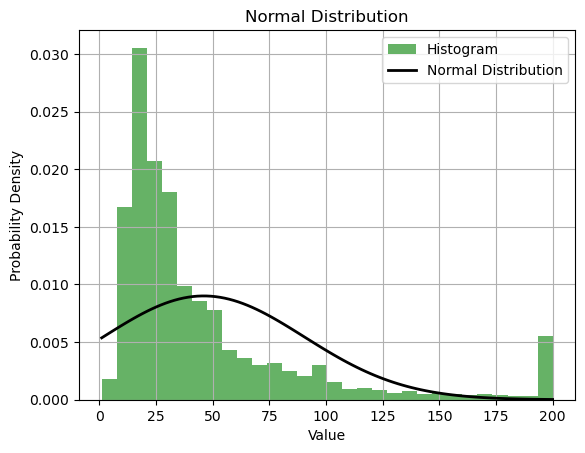

In [116]:
# 정규분포 그리기
xmin, xmax = min(songs_cnt_data), max(songs_cnt_data)
x = np.linspace(xmin, xmax, 100)
pdf = stats.norm.pdf(x, mean, std_dev)

# 히스토그램과 정규분포 그래프를 동시에 그리기
plt.hist(songs_cnt_data, bins=30, density=True, alpha=0.6, color='g', label='Histogram')
plt.plot(x, pdf, 'k', linewidth=2, label='Normal Distribution')

# 그래프 제목과 레이블 설정
plt.title("Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)

# 그래프 보여주기
plt.show()

In [118]:
import scipy
scipy.stats.skew(songs_cnt_data) # 왜도 값

2.1003433038316452

In [120]:
playlists_dup_proc['songs_cnt'].describe()

count    109247.000000
mean         46.047370
std          44.289386
min           1.000000
25%          19.000000
50%          30.000000
75%          53.000000
max         200.000000
Name: songs_cnt, dtype: float64

(array([35564., 35253., 15001.,  7142.,  5518.,  2597.,  1580.,  1210.,
          940.,  4442.]),
 array([  1. ,  20.9,  40.8,  60.7,  80.6, 100.5, 120.4, 140.3, 160.2,
        180.1, 200. ]),
 <BarContainer object of 10 artists>)

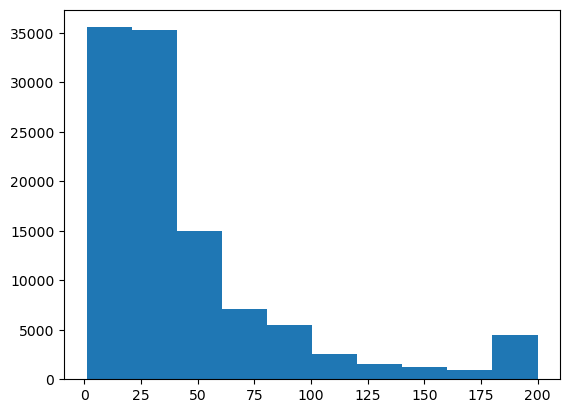

In [121]:
plt.hist(playlists_dup_proc['songs_cnt'])

In [122]:
Q1 = 19
Q3 = 53
IQR = Q3 - Q1

print(Q1-(1.5*IQR))
print(Q3+(1.5*IQR))

-32.0
104.0


- 우리 곡을 뽑아야하는 최소 개수가 5개이므로 최소를 5개로 하자

In [123]:
playlists_song_cut = playlists_dup_proc[(playlists_dup_proc['songs_cnt'] >= 5) & (playlists_dup_proc['songs_cnt'] < 105) ]  # 5~104개만 남기기
playlists_song_cut.info() # 109247 -98952 = 10295행 삭제

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98952 entries, 0 to 114705
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          98952 non-null  object
 1   id            98952 non-null  int64 
 2   plylst_title  98952 non-null  object
 3   songs         98952 non-null  object
 4   like_cnt      98952 non-null  int64 
 5   updt_date     98952 non-null  object
 6   songs_cnt     98952 non-null  int64 
 7   tags_cnt      98952 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 6.8+ MB


> 태그는?

In [124]:
playlists_song_cut['tags_cnt'] = playlists_song_cut['tags'].apply(lambda x : len(x))

C:\Users\Playdata\AppData\Local\Temp\ipykernel_10096\3179997949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playlists_song_cut['tags_cnt'] = playlists_song_cut['tags'].apply(lambda x : len(x))


In [125]:
playlists_song_cut['tags_cnt'].describe()

count    98952.000000
mean         4.202027
std          3.067990
min          1.000000
25%          2.000000
50%          3.000000
75%          7.000000
max         11.000000
Name: tags_cnt, dtype: float64

In [126]:
Q1 = 2
Q3 = 7
IQR = Q3 - Q1

print(Q1-(1.5*IQR))
print(Q3+(1.5*IQR))

-5.5
14.5


=> 이상치가 없음

> 좋아요 2개 이하(describe 시 25%가 2개임) 삭제

In [127]:
playlists_song_cut['like_cnt'].describe()

count    98952.000000
mean        77.177763
std        437.591821
min          0.000000
25%          2.000000
50%          7.000000
75%         22.000000
max      53211.000000
Name: like_cnt, dtype: float64

---

C:\Users\Playdata\AppData\Local\Temp\ipykernel_10096\2935705104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playlists_song_cut['log_likes'] = np.log1p(playlists_song_cut['like_cnt'])  # np.log1p를 사용하여 0이하 값의 로그를 취함


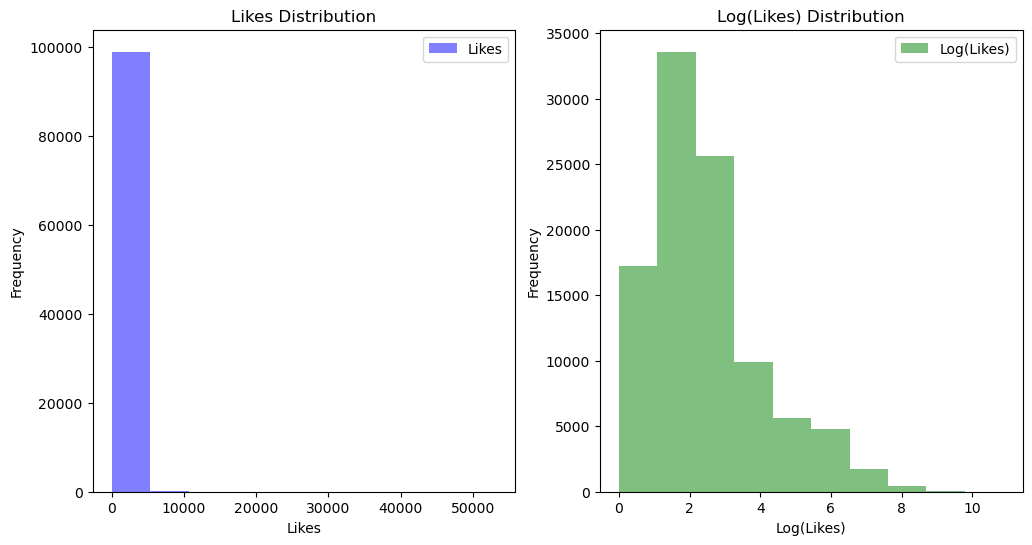

In [85]:
# 로그 변환 적용
playlists_song_cut['log_likes'] = np.log1p(playlists_song_cut['like_cnt'])  # np.log1p를 사용하여 0이하 값의 로그를 취함

# 좋아요 수의 로그 변환 결과를 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(playlists_song_cut['like_cnt'], bins=10, color='b', alpha=0.5, label='Likes')
plt.title('Likes Distribution')
plt.xlabel('Likes')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(playlists_song_cut['log_likes'], bins=10, color='g', alpha=0.5, label='Log(Likes)')
plt.title('Log(Likes) Distribution')
plt.xlabel('Log(Likes)')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [86]:
playlists_song_cut['log_likes'].describe()

count    98952.000000
mean         2.376019
std          1.656449
min          0.000000
25%          1.098612
50%          2.079442
75%          3.135494
max         10.882039
Name: log_likes, dtype: float64

In [87]:
Q1 = 1.098612
Q3 = 3.135494
IQR = Q3 - Q1

print(Q1-(1.5*IQR))
print(Q3+(1.5*IQR))

-1.9567110000000005
6.190817000000001


In [88]:
print(np.exp(Q1-(1.5*IQR)))
print(np.exp(Q3+(1.5*IQR)))

0.14132246697286754
488.244839343522


In [132]:
Q1 = 1.098612
np.exp(Q1)
# 25% 구간 값

2.9999991339957957

---

In [133]:
playlists_song_like_cut = playlists_song_cut[playlists_song_cut['like_cnt'] > 2]
playlists_song_like_cut = playlists_song_like_cut.iloc[:, :6]
playlists_song_like_cut.info()# 24860행 삭제

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74092 entries, 1 to 114705
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          74092 non-null  object
 1   id            74092 non-null  int64 
 2   plylst_title  74092 non-null  object
 3   songs         74092 non-null  object
 4   like_cnt      74092 non-null  int64 
 5   updt_date     74092 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.0+ MB


> 하영

In [168]:
# 자른 후 like_cnt describe
playlists_song_like_cut['like_cnt'].describe()

count    74092.000000
mean       102.749501
std        503.123910
min          3.000000
25%          6.000000
50%         12.000000
75%         35.000000
max      53211.000000
Name: like_cnt, dtype: float64

In [170]:
tmp = playlists_song_cut[playlists_song_cut['like_cnt'] > 6]
tmp.info()# 22197 행 삭제

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51895 entries, 8 to 114703
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          51895 non-null  object
 1   id            51895 non-null  int64 
 2   plylst_title  51895 non-null  object
 3   songs         51895 non-null  object
 4   like_cnt      51895 non-null  int64 
 5   updt_date     51895 non-null  object
 6   songs_cnt     51895 non-null  int64 
 7   tags_cnt      51895 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 3.6+ MB


## 4) song, tag 빈도수에 따라 리스트에서 빼기
- 리스트가 비워져 있으면 행 날리기

> 1회 이하 사용된 tag 리스트에서 빼기

> 영지

In [181]:
# tag usage count 계산
tag_counts = playlists_song_like_cut.explode('tags')['tags'].value_counts(ascending=True)

# 1번 이하로 사용된 태그
unique_tags = list(tag_counts[tag_counts == 1].index)

In [189]:
tag_counts.describe()

count     9299.000000
mean        33.350468
std        281.470899
min          2.000000
25%          2.000000
50%          4.000000
75%          9.000000
max      10528.000000
Name: tags, dtype: float64

In [ ]:
# tag_freq = pd.DataFrame(tag_counts).reset_index().rename(columns={'index':'tag_id', 'tags':'tag_cnt'})
# tag_freq_group = tag_freq.groupby('tag_cnt').count().reset_index()
# tag_freq_group['tag_cnt'].describe()

In [198]:
song_counts = playlists_song_like_cut.explode('songs')['songs'].value_counts()
song_counts.describe()

count    450944.000000
mean          5.878648
std          21.603451
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max        1155.000000
Name: songs, dtype: float64

In [190]:
# like cnt > 6인 걸로 해보기
# tag usage count 계산
tag_counts = tmp.explode('tags')['tags'].value_counts(ascending=True)

# 1번 이하로 사용된 태그
unique_tags = list(tag_counts[tag_counts == 1].index)

tag_counts.describe()

count    19592.00000
mean        12.12010
std        134.76122
min          1.00000
25%          1.00000
50%          1.00000
75%          3.00000
max       7302.00000
Name: tags, dtype: float64

In [199]:
song_counts = tmp.explode('songs')['songs'].value_counts()
song_counts.describe()

count    398028.000000
mean          4.914933
std          15.856652
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         894.000000
Name: songs, dtype: float64

> 하영

In [195]:
# 플레이리스트 내 song id 리스트
t_song = playlists_song_like_cut['songs']
# 플레이리스트 내 tag 리스트
t_tag = playlists_song_like_cut['tags']
# 플레이리스트 내 song id 리스트 전체 나열
song_list = [song for ply in t_song for song in ply]
# 플레이리스트 내 tag 리스트 전체 나열
tag_list = [tag for ply in t_tag for tag in ply]

# 전체 나열 리스트 중 각 song의 개수
count_song = Counter(song_list)
# 전체 나열 리스트 중 각 tag의 개수
count_tag = Counter(tag_list)

In [196]:
pd.Series(count_tag).describe()

count     9299.000000
mean        33.350468
std        281.470899
min          2.000000
25%          2.000000
50%          4.000000
75%          9.000000
max      10528.000000
dtype: float64

In [197]:
pd.Series(count_song).describe()

count    450944.000000
mean          5.878648
std          21.603451
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max        1155.000000
dtype: float64

In [191]:
# like cnt > 6인 걸로 해보기
# 플레이리스트 내 song id 리스트
t_song = tmp['songs']
# 플레이리스트 내 tag 리스트
t_tag = tmp['tags']
# 플레이리스트 내 song id 리스트 전체 나열
song_list = [song for ply in t_song for song in ply]
# 플레이리스트 내 tag 리스트 전체 나열
tag_list = [tag for ply in t_tag for tag in ply]

# 전체 나열 리스트 중 각 song의 개수
count_song = Counter(song_list)
# 전체 나열 리스트 중 각 tag의 개수
count_tag = Counter(tag_list)

In [192]:
pd.Series(count_tag).describe()

count    19592.00000
mean        12.12010
std        134.76122
min          1.00000
25%          1.00000
50%          1.00000
75%          3.00000
max       7302.00000
dtype: float64

In [194]:
pd.Series(count_song).describe()

count    398028.000000
mean          4.914933
std          15.856652
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         894.000000
dtype: float64

In [201]:
# 실험: split data 후 빈도수 측정
playlists_song_like_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74092 entries, 1 to 114705
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          74092 non-null  object
 1   id            74092 non-null  int64 
 2   plylst_title  74092 non-null  object
 3   songs         74092 non-null  object
 4   like_cnt      74092 non-null  int64 
 5   updt_date     74092 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.0+ MB


In [204]:
import random
import distutils.dir_util
import io
import os

# json write & load 함수 정의
def write_json(data, fname):
    def _conv(o):
        if isinstance(o, (np.int64, np.int32)):
            return int(o)
        raise TypeError

    parent = os.path.dirname(fname)
    distutils.dir_util.mkpath(parent)
    with io.open(fname, "w", encoding="utf-8") as f:
        json_str = json.dumps(data, ensure_ascii=False, default=_conv)
        f.write(json_str)
        
def load_json(fname):
    with open(fname, encoding='utf-8') as f:
        json_obj = json.load(f)

    return json_obj

In [206]:
playlists_song_like_cut.to_json('../0_data/like_2.json', orient='records')

In [207]:
like_2 = load_json('../0_data/like_2.json')

In [209]:
# 무작위로 데이터 섞기
random.seed(777)
random.shuffle(like_2)

# 80:20 비율로 split 하기
tot = len(like_2)
like_2_train = like_2[:int(tot*0.80)]
like_2_test = like_2[int(tot*0.80):]

# 데이터 확인
len(like_2_train), len(like_2_test)

(59273, 14819)

In [212]:
like_2_train = pd.DataFrame(like_2_train)

In [213]:
# 플레이리스트 내 song id 리스트
t_song = like_2_train['songs']
# 플레이리스트 내 tag 리스트
t_tag = like_2_train['tags']
# 플레이리스트 내 song id 리스트 전체 나열
song_list = [song for ply in t_song for song in ply]
# 플레이리스트 내 tag 리스트 전체 나열
tag_list = [tag for ply in t_tag for tag in ply]

# 전체 나열 리스트 중 각 song의 개수
count_song = Counter(song_list)
# 전체 나열 리스트 중 각 tag의 개수
count_tag = Counter(tag_list)

count    9132.000000
mean       27.143342
std       227.524911
min         1.000000
25%         2.000000
50%         3.000000
75%         7.000000
max      8447.000000
dtype: float64

In [214]:
pd.Series(count_song).describe()

count    402252.000000
mean          5.273667
std          18.250851
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         927.000000
dtype: float64

In [215]:
pd.Series(count_tag).describe()

count    9132.000000
mean       27.143342
std       227.524911
min         1.000000
25%         2.000000
50%         3.000000
75%         7.000000
max      8447.000000
dtype: float64

In [216]:
# tmp로 해보기
tmp.to_json('../0_data/like_6.json', orient='records')

In [217]:
like_6 = load_json('../0_data/like_6.json')

In [218]:
# 무작위로 데이터 섞기
random.seed(777)
random.shuffle(like_2)

# 80:20 비율로 split 하기
tot = len(like_6)
like_6_train = like_6[:int(tot*0.80)]
like_6_test = like_6[int(tot*0.80):]

# 데이터 확인
len(like_6_train), len(like_6_test)

(41516, 10379)

In [219]:
like_2_train = pd.DataFrame(like_2_train)

In [220]:
# 플레이리스트 내 song id 리스트
t_song = like_2_train['songs']
# 플레이리스트 내 tag 리스트
t_tag = like_2_train['tags']
# 플레이리스트 내 song id 리스트 전체 나열
song_list = [song for ply in t_song for song in ply]
# 플레이리스트 내 tag 리스트 전체 나열
tag_list = [tag for ply in t_tag for tag in ply]

# 전체 나열 리스트 중 각 song의 개수
count_song = Counter(song_list)
# 전체 나열 리스트 중 각 tag의 개수
count_tag = Counter(tag_list)

In [221]:
pd.Series(count_song).describe()

count    402252.000000
mean          5.273667
std          18.250851
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         927.000000
dtype: float64

In [222]:
pd.Series(count_tag).describe()

count    9132.000000
mean       27.143342
std       227.524911
min         1.000000
25%         2.000000
50%         3.000000
75%         7.000000
max      8447.000000
dtype: float64

--- 

In [223]:
ply_f = pd.read_json('../0_data/playlists_filter.json')
ply_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73014 entries, 0 to 73013
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          73014 non-null  object
 1   id            73014 non-null  int64 
 2   plylst_title  73014 non-null  object
 3   songs         73014 non-null  object
 4   like_cnt      73014 non-null  int64 
 5   updt_date     73014 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.3+ MB


In [224]:
# 플레이리스트 내 song id 리스트
t_song = ply_f['songs']
# 플레이리스트 내 tag 리스트
t_tag = ply_f['tags']
# 플레이리스트 내 song id 리스트 전체 나열
song_list = [song for ply in t_song for song in ply]
# 플레이리스트 내 tag 리스트 전체 나열
tag_list = [tag for ply in t_tag for tag in ply]

# 전체 나열 리스트 중 각 song의 개수
count_song = Counter(song_list)
# 전체 나열 리스트 중 각 tag의 개수
count_tag = Counter(tag_list)

In [225]:
pd.Series(count_song).describe()
# tag, song 1씩 뺀거인데도 count가 이상..

count    146930.000000
mean         15.418213
std          35.816483
min           3.000000
25%           4.000000
50%           6.000000
75%          12.000000
max        1151.000000
dtype: float64

In [226]:
pd.Series(count_tag).describe()

count     9266.000000
mean        33.160263
std        281.031349
min          1.000000
25%          2.000000
50%          3.000000
75%          8.000000
max      10505.000000
dtype: float64